In [7]:
#########
import torch
# import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import diffprivlib as dpl
import Other_Mean_Algs as OMA
import P_Trimed_Mean as PTA
from tqdm import tqdm
import itertools
import pickle
import os
import scipy.stats
import seaborn as sns

In [8]:
def rlln(sigma,size):
    X=np.random.laplace(size=size)
    Y=np.random.normal(size=size)
    Z=X*np.exp(sigma*Y)
    return Z

X1=rlln(1,10000)
X2=np.random.normal(size=10000)

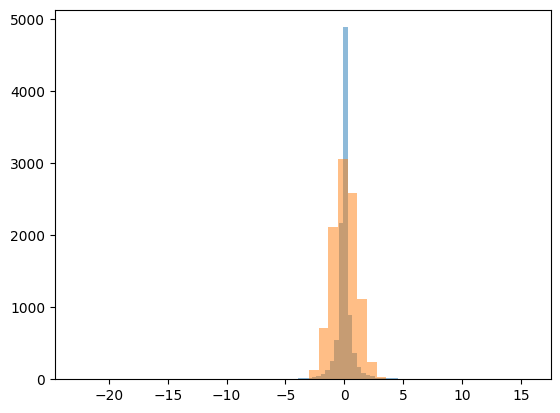

In [9]:
X1=X1/np.sqrt(X1.var())
plt.hist(X1,bins=100,alpha=0.5)
plt.hist(X2,  alpha=0.5,
         label='normal') 
plt.show()

           0          1
0   6.793315   3.231022
1   5.053455   5.415379
2  20.274618  19.879953
3  17.712963  18.871880
4  19.317020  19.091568


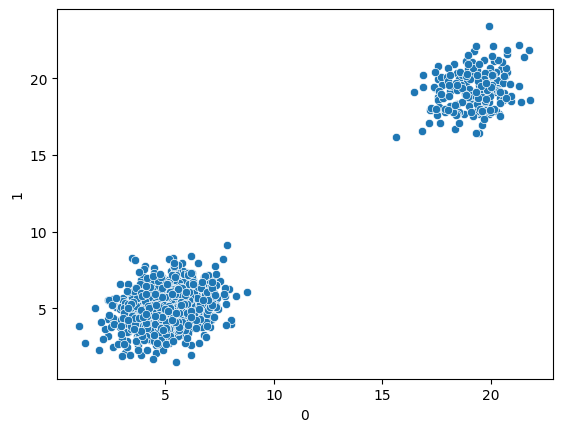

In [10]:
# n=1000
# d=4
# mix = torch.distributions.Categorical(torch.ones(2,))
#         # Stack the means and covariances to define the component distributions
# component_means = torch.stack([torch.zeros(d)-2,torch.zeros(d)+2])
# component_covariances = torch.stack([ get_cov(d), get_cov(d)])
# component_distributions = torch.distributions.MultivariateNormal(component_means, component_covariances)
# D = torch.distributions.MixtureSameFamily(mix, component_distributions)
# X=D.sample(torch.Size([n]))
# X

# Generate random covariance 
def get_cov(d):
    Sigma_k = torch.rand(512, 512)
    Sigma_k = torch.mm(Sigma_k, Sigma_k.t())
    Sigma_k.add_(torch.eye(512))
    # D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    # A=D.sample(torch.Size([d]))
    # # print(A.shape)
    # S=A @ A.t()
    # S=OMA.psd_proj_symm(S)
    return d*Sigma_k/Sigma_k.norm()

# get_cov(2).norm()
## Generate the datasets and set parameters
ns=[50,100,500,1000]
# ns=[50,100,200,300]
# rhos=[1,100]
rhos=[0.1,1]
Types=[1,2,3]
num_runs=250
# num_runs=50
# num_runs=1000

# Generate random covariance 
def get_cov(d):
    Sigma_k = torch.rand(d,d)
    Sigma_k = torch.mm(Sigma_k, Sigma_k.t())
    Sigma_k.add_(torch.eye(d))
    # D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    # A=D.sample(torch.Size([d]))
    # # print(A.shape)
    # S=A @ A.t()
    # S=OMA.psd_proj_symm(S)
    return d*Sigma_k/Sigma_k.norm()

# Gen random data 
# 1. Normal, 2. Mixture, 3. Skew, 4. Heavy tail, 5. Contamination
def generate_data(Type,n,d,eta=0.2):
    if Type==1:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), get_cov(d))
        X=D.sample(torch.Size([n]))
    elif Type==2:
        mix = torch.distributions.Categorical(torch.ones(2,))
        # Stack the means and covariances to define the component distributions
        component_means = torch.stack([torch.zeros(d)-5,torch.zeros(d)+5])
        component_covariances = torch.stack([ get_cov(d), get_cov(d)])
        component_distributions = torch.distributions.MultivariateNormal(component_means, component_covariances)
        D = torch.distributions.MixtureSameFamily(mix, component_distributions)
        X=D.sample(torch.Size([n]))
    elif Type==3:
        D = torch.distributions.Exponential(torch.tensor([1.0]))
        X=D.sample(torch.Size((n,d)))-1
    elif Type==4:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
        A=D.sample((d,))
        D = torch.distributions.StudentT(df=3.0)
        X= D.sample(torch.Size((n,d))) @ A.t()
    elif Type==5:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), get_cov(d))
        X=D.sample(torch.Size([n]))
        X[0:int(n*eta),:]=X[0:int(n*eta),:]+10*np.sqrt(d)
        X=X[torch.randperm(n),:] 
    # elif Type==6:
    #     D = torch.distributions.Exponential(torch.tensor([1.0]))
    #     X=D.sample(torch.Size((n,d)))-1
    #     X[0:int(n*eta),:]=X[0:int(n*eta),:]+10*np.sqrt(d)
    #     X=X[torch.randperm(n),:] 
    return X


X=generate_data(2,1000,2,eta=0.2)+5
X=generate_data(5,1000,2,eta=0.2)+5
X=torch.squeeze(X)
df=pd.DataFrame(X)
print(df.head())
sns.scatterplot(data=df,x=0,y=1)
plt.show()
# sns.histplot(data=df,x=0,y=1)
# plt.show()
# plt.plot(X)
# print(df.head())

In [11]:

def one_run(n,d,rho,Type,seed=1):
    torch.manual_seed(seed)
    X=generate_data(Type,n,d,eta=0.2)+5
    radius=50
    X=X.numpy()
    rng=np.random.default_rng(seed=seed)
    top=int(np.min((100,int(0.05*n))))
    constant=rng.integers(low=1, high=top, size=1)
    ## Private trimmed mean
    tm,tm_noise=PTA.private_tm_zCDP_split(X, -radius,radius,rho/4,rho/4,rho/2,beta=1.001,constant=constant,eta=0,seed=seed)
    ## BUN
    bun, bun_noise=OMA.bun_2019_split(X, -radius,radius, rho,m=constant[0],t=0.1,seed=seed)
    return [tm,tm_noise,bun,bun_noise]

rng=np.random.default_rng()
c=rng.integers(low=1, high=1000, size=1)
one_run(50,1,0.1,3,c)


[5.08247988243103,
 array([-0.110627]),
 array([[5.0538025]], dtype=float32),
 array([-20.73915772])]

In [12]:
total=len(ns)*len(rhos)*5
count=0
num_runs=250
for n in ns:
    print(count/total)
    for rho in rhos:
        for Type in Types:
            mean_ests=[]
            file_name='output_1d/noise_comparison_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'_nr_'+str(num_runs)+'.pkl'
            if not os.path.exists(file_name):
            # if True:
                        # print(count/total)
                        # print('starting ',n,d,epsilon,Type)
                for i in range(num_runs):
                    mean_ests.append(one_run(n,1,rho,Type,seed=i))
                            # Pickling to a filen,d,rho,Type,constant,eta,seed=1
                    with open(file_name, 'wb') as file:
                        pickle.dump(mean_ests, file)                        
                        # print('completed ',n,d,epsilon,Type)
                    # else:
                    #     print("Skipped!")
                count+=1
                    
            else:
                count+=len(rhos)*5
            # print(count/total)

0.0
1.5
3.0
4.5


In [13]:
# total=len(ns)*len(rhos)*5
# count=0
# for n in [50]:
#     print(count/total)
#     for rho in [0.1]:
#         for Type in [1]:
#             n=50
#             Type=1
#             rho=0.1
#             mean_ests=[]
#             # file_name='output_1d/noise_comparison_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'_nr_'+str(num_runs)+'.pkl'
#             # if not os.path.exists(file_name):
#             # if True:
#                         # print(count/total)
#                         # print('starting ',n,d,epsilon,Type)
#             for i in range(num_runs):
#                 mean_ests.append(one_run(n,1,rho,Type,seed=i))
#                             # Pickling to a filen,d,rho,Type,constant,eta,seed=1
#                     # with open(file_name, 'wb') as file:
#                         # pickle.dump(mean_ests, file)                        
#                         # print('completed ',n,d,epsilon,Type)
#                     # else:
#                     #     print("Skipped!")
#             count+=1

        

In [14]:
# for i in range(50):
#     print(mean_ests[i][0])

In [15]:
# Now analyze the output
# Make a Data frame, rows are n, d, eps, type , columns is the 4 different methods 
# ns=ns[:-1]
def get_mse(n,rho,Type):
    if(rho==1):
         rho=int(rho)
    file_name='output_1d/noise_comparison_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'_nr_'+str(num_runs)+'.pkl'
    # print(file_name)
    try:
        with open(file_name, 'rb') as file:
            mean_list = pickle.load(file)
        noises=[(x[1],x[3]) for x in mean_list]
        means=[[x[0],x[2][0]] for x in mean_list]
        # print(means)
        list_of_mse=[[np.full(1, np.nan) if y is None else y for y in x] for x in means]
        # list_of_mse=[[np.full(1, np.nan) if np.array_equal(y,np.ones(1)*-1000)  else y for y in x] for x in list_of_mse]
        list_of_mse=[((np.vstack(x)-5)**2) for x in list_of_mse]
        # list_of_mse[0].shape
        list_of_mse=[x.sum(axis=1) for x in list_of_mse]
        # list_of_mse[0].shape
        MSEs=[np.vstack(x) for x in list_of_mse]
        nans=np.mean(np.isnan(np.hstack(MSEs)),axis=1)
        if nans.sum()>0:
            file_name='output_1d/noise_comparison_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'.pkl'
            print(file_name+' ',str(nans))
        MSEs=np.nanmean(np.hstack(MSEs),axis=1)
        return MSEs
    except:
        if n>1:
            print(file_name)
        a = np.empty(9)
        return a.fill(np.nan)

def get_mse_wrapper(x):
    # print(x['n'])
        return get_mse(int(x['n']),x['rho'],int(x['Type']))


combinations = list(itertools.product(ns, rhos,  Types))
results=pd.DataFrame(combinations, columns=['n', 'rho', 'Type'])


results.head()

# results
# n=100
# rho=1
# Type=1

nmz=['TM','Bun_H']
# results[['CP','TM']]= results.apply(get_mse_wrapper, axis=1, result_type='expand')
results[nmz]= results.apply(get_mse_wrapper, axis=1, result_type='expand')
results.head()

,n,rho,Type,TM,Bun_H
0,50,0.1,1,0.020228,0.020137
1,50,0.1,2,0.498444,0.533273
2,50,0.1,3,0.023382,0.024963
3,50,1.0,1,0.020228,0.020137
4,50,1.0,2,0.498444,0.533273


In [16]:



# tm,tm_c,bun,duchi,kam]
# Melt the DataFrame to have two columns: 'MSE' and 'estimator'
results_melted = results.melt(id_vars=['n', 'rho', 'Type'], 
                              value_vars=nmz, 
                              var_name='estimator', 
                              value_name='MSE')

# results[nmz]=np.log(results[nmz])

results_melted.head()



,n,rho,Type,estimator,MSE
0,50,0.1,1,TM,0.020228
1,50,0.1,2,TM,0.498444
2,50,0.1,3,TM,0.023382
3,50,1.0,1,TM,0.020228
4,50,1.0,2,TM,0.498444


In [17]:
results_melted2=results_melted[['n','Type','estimator','MSE']].groupby(['n','Type','estimator']).mean()
results_melted2.head()

MSE
n  Type estimator          
50 1    Bun_H      0.020137
        TM         0.020228
   2    Bun_H      0.533273
        TM         0.498444
   3    Bun_H      0.024963

In [18]:

new_table=pd.pivot_table(results_melted2,values=['MSE'],columns=['Type','estimator'],index=['n'])
new_table

tmp=new_table.style.format(decimal='.', thousands='.', precision=4)
latex_table =tmp.to_latex()
print(latex_table)

\begin{tabular}{lrrrrrr}
 & \multicolumn{6}{r}{MSE} \\
Type & \multicolumn{2}{r}{1} & \multicolumn{2}{r}{2} & \multicolumn{2}{r}{3} \\
estimator & Bun_H & TM & Bun_H & TM & Bun_H & TM \\
n &  &  &  &  &  &  \\
50 & 0.0201 & 0.0202 & 0.5333 & 0.4984 & 0.0250 & 0.0234 \\
100 & 0.0105 & 0.0104 & 0.3132 & 0.2868 & 0.0147 & 0.0111 \\
500 & 0.0025 & 0.0025 & 0.0507 & 0.0466 & 0.0072 & 0.0023 \\
1000 & 0.0013 & 0.0013 & 0.0284 & 0.0258 & 0.0068 & 0.0014 \\
\end{tabular}



In [19]:
# Now analyze the output
# Make a Data frame, rows are n, d, eps, type , columns is the 4 different methods 
# ns=ns[:-1]
def get_noise(n,rho,Type):
    if(rho==1):
        rho=int(rho)
    file_name='output_1d/noise_comparison_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'_nr_'+str(num_runs)+'.pkl'
    # print(file_name)
    # try:
    with open(file_name, 'rb') as file:
        mean_list = pickle.load(file)
    # noises=[]
    # for x in mean_list:
    #     #  print(x)
    #      print([x[1].item(),x[3].item()])
    #      np.array([x[1].item(),x[3].item()])
    # noises=[print(np.array([x[1][0],x[3][0]])) for x in mean_list]
    noises=[np.array([x[1].item(),x[3].item()]) for x in mean_list]
    # print(n,rho,Type)
    noises=np.array(noises).squeeze()
    return np.var(noises,axis=0)

def get_noise_wrapper(x):
    # print(x['n'])
        return get_noise(int(x['n']),x['rho'],int(x['Type']))





In [21]:

combinations = list(itertools.product(ns, rhos,  Types))
results_noise=pd.DataFrame(combinations, columns=['n', 'rho', 'Type'])

# results
# n=100
# rho=100
# Type=1
# get_noise(n,rho,Type)

nmz=['TM','Bun']
# results[['CP','TM']]= results.apply(get_mse_wrapper, axis=1, result_type='expand')
results_noise[nmz]= results_noise.apply(get_noise_wrapper, axis=1, result_type='expand')
results_noise[nmz].head()
# tm,tm_c,bun,duchi,kam]
# Melt the DataFrame to have two columns: 'MSE' and 'estimator'
results_noise

,n,rho,Type,TM,Bun
0,50,0.1,1,1.824130,148.169869
1,50,0.1,2,8.445221,148.169869
2,50,0.1,3,2.539738,148.169869
3,50,1.0,1,0.004993,3.874128
4,50,1.0,2,0.059787,3.874128
5,50,1.0,3,0.003383,3.874128
6,100,0.1,1,0.010333,21.960776
7,100,0.1,2,0.141751,21.975413
8,100,0.1,3,0.008005,21.960776
9,100,1.0,1,0.001537,0.564870


In [22]:


results_melted_noise = results_noise.melt(id_vars=['n', 'rho', 'Type'], 
                              value_vars=nmz, 
                              var_name='estimator', 
                              value_name='Variance')

# results[nmz]=np.log(results[nmz])

results_melted_noise.head()

,n,rho,Type,estimator,Variance
0,50,0.1,1,TM,1.824130
1,50,0.1,2,TM,8.445221
2,50,0.1,3,TM,2.539738
3,50,1.0,1,TM,0.004993
4,50,1.0,2,TM,0.059787


In [23]:
# pd.pivot_table(results_noise,columns=['Type'],values=['TM','Bun'],index=['n','rho']).reset_index()
new_table=pd.pivot_table(results_melted_noise,values=['Variance'],columns=['Type','estimator'],index=['rho','n'])
new_table

tmp=new_table.style.format("{:.2e}")
latex_table =tmp.to_latex()
print(latex_table)



\begin{tabular}{llrrrrrr}
 &  & \multicolumn{6}{r}{Variance} \\
 & Type & \multicolumn{2}{r}{1} & \multicolumn{2}{r}{2} & \multicolumn{2}{r}{3} \\
 & estimator & Bun & TM & Bun & TM & Bun & TM \\
rho & n &  &  &  &  &  &  \\
\multirow[c]{4}{*}{0.100000} & 50 & 1.48e+02 & 1.82e+00 & 1.48e+02 & 8.45e+00 & 1.48e+02 & 2.54e+00 \\
 & 100 & 2.20e+01 & 1.03e-02 & 2.20e+01 & 1.42e-01 & 2.20e+01 & 8.00e-03 \\
 & 500 & 2.21e-01 & 7.22e-04 & 2.26e-01 & 5.86e-03 & 2.22e-01 & 6.05e-04 \\
 & 1000 & 3.26e-02 & 1.95e-04 & 3.67e-02 & 1.85e-03 & 3.27e-02 & 1.70e-04 \\
\multirow[c]{4}{*}{1.000000} & 50 & 3.87e+00 & 4.99e-03 & 3.87e+00 & 5.98e-02 & 3.87e+00 & 3.38e-03 \\
 & 100 & 5.65e-01 & 1.54e-03 & 5.65e-01 & 1.63e-02 & 5.65e-01 & 9.81e-04 \\
 & 500 & 5.35e-03 & 7.81e-05 & 5.50e-03 & 7.50e-04 & 5.36e-03 & 5.64e-05 \\
 & 1000 & 7.36e-04 & 2.06e-05 & 8.48e-04 & 1.88e-04 & 7.39e-04 & 1.48e-05 \\
\end{tabular}

